# Chapter 17

## Load packages / modules

Standard library:
- Printf for string formatting
- Dates for `Date` values and date formatting
- Statistics for mean and std functions
- Random for bootstrap sampling

External:
- CSV.jl to load CSV files
- DataFrames.jl for tabular data
- CategoricalArrays.jl for working with categorical data columns and the `cut` function
- PyCall.jl for using the Python Statsmodels package
- GLM.jl for models
- CairoMakie.jl for plotting

In [1]:
using Printf, Dates, Statistics, Random
using CSV, DataFrames, CategoricalArrays, PyCall, GLM, CairoMakie

## Load data

In [2]:
nhefs_all = DataFrame(CSV.File("nhefs.csv"));

In [3]:
size(nhefs_all)

(1629, 64)

In [4]:
for s in [:education, :exercise, :active]
    nhefs_all[!, s] = categorical(nhefs_all[!, s])
end

## Section 17.1

Check the number that died during follow-up

In [5]:
death = nhefs_all.death
@printf "      # died: %4d\n" sum(death)
@printf "# didn't die: %4d" sum(1 .- death)

      # died:  318
# didn't die: 1311

Check the number of deaths for untreated and treated

In [6]:
combine(groupby(nhefs_all, :qsmk), :death => sum)

,qsmk,death_sum
,Int64,Int64
1,0,216
2,1,102


Check the first and last dates of recorded death

In [7]:
dths = nhefs_all[.! ismissing.(nhefs_all.yrdth), :]
date_death = [
    Date(1900 + dths.yrdth[i], dths.modth[i], dths.dadth[i])
    for i in 1:nrow(dths)
];

In [8]:
println("first death: ", Dates.format(minimum(date_death), "uuu dd, yyyy"))
println(" last death: ", Dates.format(maximum(date_death), "uuu dd, yyyy"))

first death: Jan 08, 1983
 last death: Dec 12, 1992


Note this means that at least one person died in the last month of the study, month 120.

#### Program 17.1

Add `longevity` and `survived` to the data set

The `longevity` will be the number of months of follow-up lived until death. If the individual did not die, the value is set to 121, the number of follow-up months plus 1. This is different from the book, which uses 120. Using 121 might be unorthodox, but this allows me to more easily differentiate someone who died in month 120 vs someone who didn't have a recorded death.

In [9]:
longevity = (nhefs_all.yrdth .- 83) .* 12 .+ nhefs_all.modth
longevity[ismissing.(longevity)] .= 121

nhefs_all.longevity = longevity;

In [10]:
nhefs_all.survived = (1 .- nhefs_all.death);

Percent of survived for untreated and treated

In [11]:
combine(
    groupby(nhefs_all, :qsmk),
    :survived => (col -> "$(round(100 * mean(col), digits=1))%") => :survived
)

,qsmk,survived
,Int64,String
1,0,82.0%
2,1,76.2%


Log-rank test: "a common statistical test to compare survival curves", pg 211 margin

We'll use the Python Statsmodels package for this

In [12]:
sm = pyimport("statsmodels.api");

In [13]:
chisq, pvalue = sm.duration.survdiff(
    nhefs_all.longevity,
    nhefs_all.death,
    nhefs_all.qsmk
)

@printf "log-rank test p-value: %0.3f" pvalue

log-rank test p-value: 0.005

#### Survival curve plot

Figure 17.1

This plot is constructed by iterating through months and measuring the fraction of longevity values greater than that month. Those fraction values are the survival curve values.

We'll start at zero months, where survival is guaranteed to be 100%. (And since survival at zero months is guaranteed to be 100% we could also start at month 1 without loss of information.) For the two treatment values, the values will end at the last month with a recorded death.

In [14]:
longevity0 = nhefs_all.longevity[nhefs_all.qsmk .== 0]
longevity1 = nhefs_all.longevity[nhefs_all.qsmk .== 1];

In [15]:
# non-quitters
max0 = Int(maximum(longevity0[longevity0 .<= 120]))  # max longevity for non-quitters
surv_curve_0 = [
    sum(longevity0 .> i) / size(longevity0, 1)  # fraction of longevities greather than current month i
    for i in 0:max0
]

# quitters
max1 = Int(maximum(longevity1[longevity1 .<= 120]))  # max longevity for quitters
surv_curve_1 = [
    sum(longevity1 .> i) / size(longevity1, 1)  # fraction of longevities greather than current month i
    for i in 0:max1
];

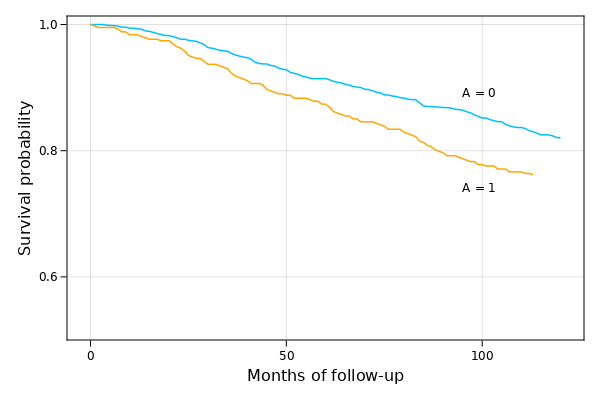

In [16]:
fig = Figure(resolution=(600, 400)) 
ax = Axis(
    fig[1, 1],
    xlabel="Months of follow-up",
    ylabel="Survival probability",
    xticklabelsize=12,
    yticklabelsize=12
)

lines!(
    ax,
    collect(0:size(surv_curve_0, 1) - 1),
    surv_curve_0,
    color=:deepskyblue
)

lines!(
    ax,
    collect(0:size(surv_curve_1, 1) - 1),
    surv_curve_1,
    color=:orange
)

text!(
    ax,
    ["A = 0", "A = 1"],
    position=[(95, 0.88), (95, 0.73)],
    textsize=12,
)

ylims!(ax, 0.5, nothing)

fig

Hazard at 120 months for treated

In [17]:
numer = sum(longevity1 .== 120)
denom = sum(longevity1 .> 119)
@printf "%s = %0.2f%%" "$numer/$denom" (numer * 100.0 / denom)

0/326 = 0.00%

Hazard at 120 months for untreated

In [18]:
numer = sum(longevity0 .== 120)
denom = sum(longevity0 .> 119)
@printf "%s = %0.2f%%" "$numer/$denom" (numer * 100.0 / denom)

1/986 = 0.10%

The book has another description of how to calculate survival on pg 212:

$$
\text{Pr}[D_k = 0] = \prod_{m=1}^k \text{Pr}[D_m  =0 | D_{m-1} = 0]
$$

"That is, the survival at $k$ equals the product of one minus the hazard at all previous times."

And hazard at $k$ can be estimated "by dividing the number of cases during the interval $k$ by the number of individuals alive at the end of interval $k-1$."

I'll show that using this description of survival gives (roughly) the same values for `qsmk` = 0.

In [19]:
hazard0 = [
    sum(longevity0 .== i) / sum(longevity0 .>= (i - 1))
    for i in 0:max0
];

Survival curves will be calculated from hazard values multiple times throughout the notebook, so I'll make a function

In [20]:
function survival_curve(hazard)
    survival = zeros(length(hazard))
    survival[1] = 1 - hazard[1]
    for i in 2:length(hazard)
        survival[i] = (1 - hazard[i]) * survival[i - 1]
    end
    return survival
end

survival_curve (generic function with 1 method)

In [21]:
survival0_v2 = survival_curve(hazard0);

In [22]:
surv_curve_0[1:6]

6-element Vector{Float64}:
 1.0
 1.0
 1.0
 1.0
 0.9991673605328892
 0.9983347210657785

In [23]:
survival0_v2[1:6]

6-element Vector{Float64}:
 1.0
 1.0
 1.0
 1.0
 0.9991673605328892
 0.9983354143542607

In [24]:
max_diff = maximum(abs.(surv_curve_0 .- survival0_v2))
@printf "maximum difference between methods: %0.2e" max_diff

maximum difference between methods: 2.89e-04

This difference is likely due to a propagation of rounding errors, and probably wouldn't be visible on the plot

## Section 17.2

#### Program 17.2

Create the person-time format

The following function is a straightforward way to create the person-time format, but it's slower than the more complicated function that follows. Speed will be important, because the function will be used repeatedly at the end of this notebook.

In [25]:
# simpler, but slower than the function below

function simple_person_time_format(data)
    # number of rows per subject, i.e., number of months in the study
    n_months_vec = min.(data.longevity, 120)

    # vectors to collect expanded info
    rows = []
    time = []
    event = []  # will be 1 only for the month of death, 0 otherwise

    # iterate through subjects and create expanded info
    for (row, n_months) in zip(eachrow(data), n_months_vec)
        for month in 0:(n_months - 1)
            push!(rows, row)
            push!(time, month)
            push!(event, (month == (n_months - 1) & row.death == 1))
        end
    end

    # create DataFrame
    output = DataFrame(rows)
    output.time = time
    output.event = event

    return output
end

simple_person_time_format (generic function with 1 method)

The following function is faster. It will be used throughout this notebook to create the person-time format.

(This could likely be optimized further.)

In [26]:
# This function is specifally for the data in this notebook

# accumulate rows in a dict, then convert the dict to DataFrame;
# the dict will contain each column of the input data, plus
# `time`, which keeps track of month within individual, and
# `event`, a 0/1 indicator of death for each month

# There are ways to do this with fewer lines of code, but 

function person_time_format(data::AbstractDataFrame)
    # to collect person-time values, each name will map to
    # a vector of vectors, one sub-vector for each original row
    newrows = Dict{String, Vector{Vector{Union{Real, Missing}}}}(
        name => [] for name in names(data)
    )
    merge!(newrows, Dict("time" => [], "event" => []))

    # expand each original row into person-time values
    for row in eachrow(data)
        # number of rows per subject, i.e., number of months in the study
        n_mos = min(Int(row.longevity), 120)
        for name in names(data)
            push!(newrows[name], repeat([row[name]], n_mos))
        end
        push!(newrows["time"], collect(0:n_mos - 1))
        push!(newrows["event"], repeat([0], n_mos))
        if row.death == 1
            newrows["event"][end][end] = 1
        end
    end

    # flatten each vector of vectors
    newdata = Dict(
        name => [value for subvec in newrows[name] for value in subvec]
        for name in keys(newrows)
    )

    newdf = DataFrame(newdata)
    
    # make sure these columns are recognized as categorical
    for s in [:education, :exercise, :active]
        newdf[!, s] = categorical(newdf[!, s])
    end
    
    return newdf
end

person_time_format (generic function with 1 method)

In [27]:
pt_data = person_time_format(nhefs_all);

In [28]:
size(pt_data)

(176764, 68)

"An easy way to parametrically estimate the hazards is to fit a logistic regression model ...", pg 213

In [29]:
spec = @formula(
    event ~ qsmk
          + time + time ^ 2
          + qsmk & time + qsmk & time ^ 2
)
model = glm(spec, pt_data, Binomial(), LogitLink())

StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Vector{Float64}, Binomial{Float64}, LogitLink}, GLM.DensePredChol{Float64, LinearAlgebra.Cholesky{Float64, Matrix{Float64}}}}, Matrix{Float64}}

event ~ 1 + qsmk + time + :(time ^ 2) + qsmk & time + qsmk & :(time ^ 2)

Coefficients:
───────────────────────────────────────────────────────────────────────────────────────
                        Coef.   Std. Error       z  Pr(>|z|)     Lower 95%    Upper 95%
───────────────────────────────────────────────────────────────────────────────────────
(Intercept)      -6.9956       0.230935     -30.29    <1e-99  -7.44823      -6.54298
qsmk              0.335476     0.396966       0.85    0.3981  -0.442562      1.11351
time              0.0195969    0.00841329     2.33    0.0198   0.00310717    0.0360867
time ^ 2         -0.000125565  6.6856e-5     -1.88    0.0604  -0.000256601   5.46997e-6
qsmk & time       0.0120786    0.0150276      0.80    0.4215  -0.0173749     0.041532
qsmk

Create predictions for each time point, for both `qsmk == 0` and `qsmk == 1`

In [30]:
A0_pred = predict(model, DataFrame(time = collect(0:119), qsmk = repeat([0], 120)))
A1_pred = predict(model, DataFrame(time = collect(0:119), qsmk = repeat([1], 120)));

Just a quick look at the values of `A0_pred`

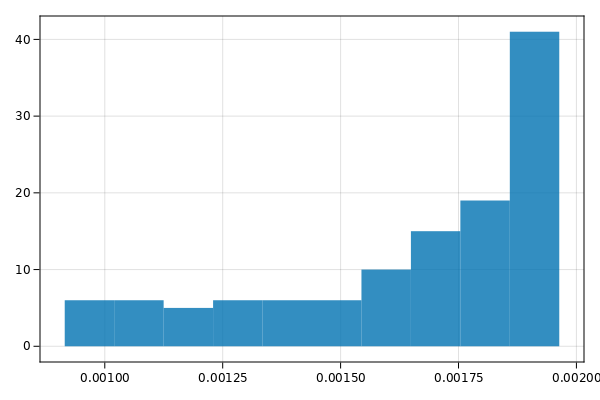

In [31]:
fig = Figure(resolution=(600, 400)) 
ax = Axis(
    fig[1, 1],
    xticklabelsize=12,
    yticklabelsize=12
)

hist!(ax, A0_pred, bins=10)

fig

Create the model-based survival curves, and recreate Figure 17.4

The `survival_curve` function below was defined in cell 20 above. For explanation, see the text between cells 18 and 19.

In [32]:
model_surv_0 = survival_curve(A0_pred)
model_surv_1 = survival_curve(A1_pred);

Figure 17.4

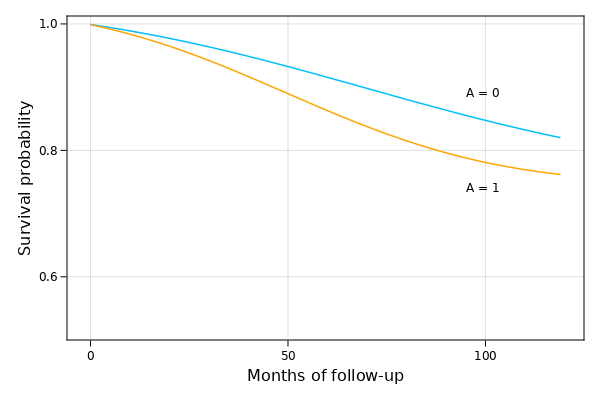

In [33]:
fig = Figure(resolution=(600, 400)) 
ax = Axis(
    fig[1, 1],
    xlabel="Months of follow-up",
    ylabel="Survival probability",
    xticklabelsize=12,
    yticklabelsize=12
)

lines!(ax, collect(0:119), model_surv_0, color=:deepskyblue)

lines!(ax, collect(0:119), model_surv_1, color=:orange)

text!(
    ax,
    ["A = 0", "A = 1"],
    position=[(95, 0.88), (95, 0.73)],
    textsize=12,
)

ylims!(ax, 0.5, nothing)

fig

"These curves are a smooth version of those in Figure 17.1", pg 213

Plot the new parametric version and the previous nonparametric version together, just to see how well they line up

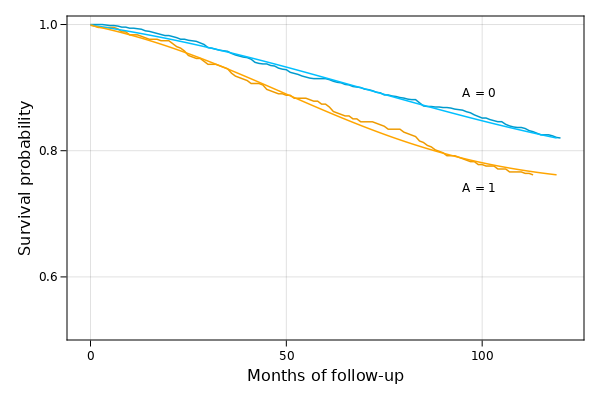

In [34]:
fig = Figure(resolution=(600, 400)) 
ax = Axis(
    fig[1, 1],
    xlabel="Months of follow-up",
    ylabel="Survival probability",
    xticklabelsize=12,
    yticklabelsize=12
)

lines!(
    ax,
    collect(0:size(surv_curve_0, 1) - 1),
    surv_curve_0,
    color=:deepskyblue3
)

lines!(
    ax,
    collect(0:size(surv_curve_1, 1) - 1),
    surv_curve_1,
    color=:orange2
)

lines!(ax, collect(0:119), model_surv_0, color=:deepskyblue)

lines!(ax, collect(0:119), model_surv_1, color=:orange)

text!(
    ax,
    ["A = 0", "A = 1"],
    position=[(95, 0.88), (95, 0.73)],
    textsize=12,
)

ylims!(ax, 0.5, nothing)

fig

## Section 17.4

#### Program 17.3

"The estimation of IP weighted survival curves has two steps"

"First, we estimate the stabilized IP weights $SW^A$", pg 217

We'll once again borrow a function from Chapter 12 to create IP weights

In [35]:
"""
    logit_ip_weights(spec, data, y_name)

Create IP weights from logistic regression

"""
function logit_ip_weights(spec, data, y_name)
    model = glm(spec, data, Binomial(), LogitLink())
    y = data[!, y_name]
    weights = zeros(nrow(data))
    weights[y .== 1] = predict(model, data[y .== 1, :])
    weights[y .== 0] = 1 .- predict(model, data[y .== 0, :])
    return weights
end

logit_ip_weights

In [36]:
spec = @formula(
    qsmk ~ sex
         + race
         + education
         + exercise
         + active
         + age + age ^ 2
         + wt71 + wt71 ^ 2
         + smokeintensity + smokeintensity ^ 2
         + smokeyrs + smokeyrs ^ 2
);

In [37]:
ip_denom = logit_ip_weights(spec, nhefs_all, :qsmk);

In [38]:
pr_qsmk = mean(nhefs_all.qsmk)

ip_numer = zeros(size(ip_denom, 1))
ip_numer[nhefs_all.qsmk .== 0] .= 1 .- pr_qsmk
ip_numer[nhefs_all.qsmk .== 1] .= pr_qsmk;

In [39]:
ip_weights = ip_numer ./ ip_denom;

In [40]:
println("Stabilized weights")
println(" min   mean    max")
println("------------------")
@printf "%04.2f   %04.2f   %04.2f" minimum(ip_weights) mean(ip_weights) maximum(ip_weights)

Stabilized weights
 min   mean    max
------------------
0.33   1.00   4.21

"Second, using the person-time format, we fit a harzards model like the one described in Section 17.2, except that individuals are weighted by their estimated $SW^A$", pg 217

So, recreate the person-time dataset, but with weights, and fit the model. We can create the person-time format by adding the IP weights to the dataset, and using the function `person_time_format` from above. Since that function expands every column into the person-time format, it'll handle the weights too.

In [41]:
nhefs_all.weight = ip_weights;

In [42]:
pt_data = person_time_format(nhefs_all);

In [43]:
model = glm(
    @formula(event ~ qsmk + qsmk & time + qsmk & time^2 + time + time^2),
    pt_data,
    Binomial(),
    LogitLink(),
    wts=pt_data.weight
)

StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Vector{Float64}, Binomial{Float64}, LogitLink}, GLM.DensePredChol{Float64, LinearAlgebra.Cholesky{Float64, Matrix{Float64}}}}, Matrix{Float64}}

event ~ 1 + qsmk + time + :(time ^ 2) + qsmk & time + qsmk & :(time ^ 2)

Coefficients:
───────────────────────────────────────────────────────────────────────────────────────
                        Coef.   Std. Error       z  Pr(>|z|)     Lower 95%    Upper 95%
───────────────────────────────────────────────────────────────────────────────────────
(Intercept)      -6.897        0.22076      -31.24    <1e-99  -7.32968      -6.46431
qsmk             -0.179383     0.439873      -0.41    0.6834  -1.04152       0.682752
time              0.0188875    0.00805274     2.35    0.0190   0.00310438    0.0346705
time ^ 2         -0.000118117  6.39918e-5    -1.85    0.0649  -0.000243538   7.30471e-6
qsmk & time       0.0189454    0.0164026      1.16    0.2481  -0.0132031     0.051094
qsm

Plotting the curves is the same as last plot

In [44]:
A0_pred = predict(model, DataFrame(time = collect(0:119), qsmk = repeat([0], 120)))
A1_pred = predict(model, DataFrame(time = collect(0:119), qsmk = repeat([1], 120)));

The `survival_curve` function below was defined in cell 22 above. For explanation, see the text between cells 20 and 21.

In [45]:
surv_ip_0 = survival_curve(A0_pred)
surv_ip_1 = survival_curve(A1_pred);

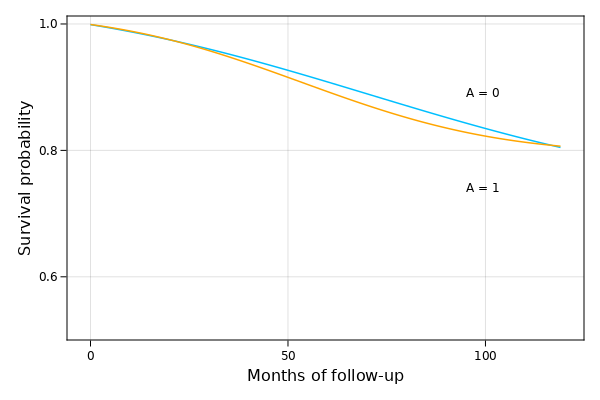

In [46]:
fig = Figure(resolution=(600, 400)) 
ax = Axis(
    fig[1, 1],
    xlabel="Months of follow-up",
    ylabel="Survival probability",
    xticklabelsize=12,
    yticklabelsize=12
)

lines!(ax, collect(0:119), surv_ip_0, color=:deepskyblue)

lines!(ax, collect(0:119), surv_ip_1, color=:orange)

text!(
    ax,
    ["A = 0", "A = 1"],
    position=[(95, 0.88), (95, 0.73)],
    textsize=12,
)

ylims!(ax, 0.5, nothing)

fig

Plot the curves on top of the curves from the previous model, to see how they've changed

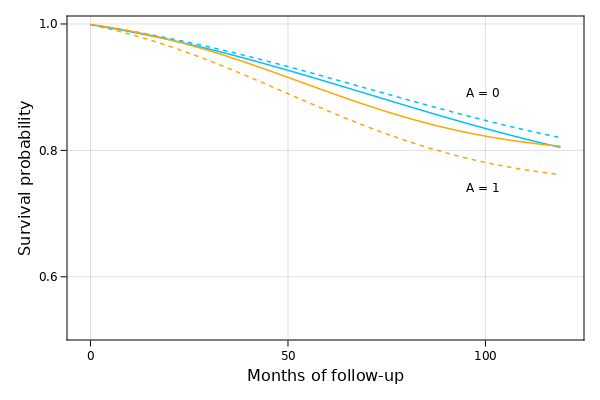

In [47]:
fig = Figure(resolution=(600, 400)) 
ax = Axis(
    fig[1, 1],
    xlabel="Months of follow-up",
    ylabel="Survival probability",
    xticklabelsize=12,
    yticklabelsize=12
)

lines!(ax, collect(0:119), model_surv_0, linestyle=:dash, color=:deepskyblue)
lines!(ax, collect(0:119), model_surv_1, linestyle=:dash, color=:orange)

lines!(ax, collect(0:119), surv_ip_0, color=:deepskyblue)
lines!(ax, collect(0:119), surv_ip_1, color=:orange)

text!(
    ax,
    ["A = 0", "A = 1"],
    position=[(95, 0.88), (95, 0.73)],
    textsize=12,
)

ylims!(ax, 0.5, nothing)

fig

In [48]:
println("survival estimates")
@printf "     smoking cessation: %0.1f%%\n" surv_ip_1[end] * 100
@printf "  no smoking cessation: %0.1f%%\n" surv_ip_0[end] * 100

survival estimates
     smoking cessation: 80.7%
  no smoking cessation: 80.5%


#### Create 500 boostrap samples to get confidence intervals

In [49]:
function survival_difference(boot_data)
    model = glm(
        @formula(event ~ qsmk + qsmk & time + qsmk & time^2 + time + time^2),
        boot_data,
        Binomial(),
        LogitLink(),
        wts=boot_data.weight
    )
    A0_pred = predict(model, DataFrame(time = collect(0:119), qsmk = repeat([0], 120)))
    A1_pred = predict(model, DataFrame(time = collect(0:119), qsmk = repeat([1], 120)));
    surv_ip_0 = survival_curve(A0_pred)
    surv_ip_1 = survival_curve(A1_pred)
    min_diff = minimum(surv_ip_1 .- surv_ip_0)
    end_diff = surv_ip_1[end] - surv_ip_0[end]
    return min_diff, end_diff
end

survival_difference (generic function with 1 method)

The next cell will take a while to run

In [50]:
num_samples = 500

min_diff_samples = zeros(num_samples)
end_diff_samples = zeros(num_samples)
for i in 1:num_samples
    boot_indices = rand(1:nrow(pt_data), nrow(pt_data))
    boot_data = pt_data[boot_indices, :]
    min_diff, end_diff = survival_difference(boot_data)
    min_diff_samples[i] = min_diff
    end_diff_samples[i] = end_diff
end

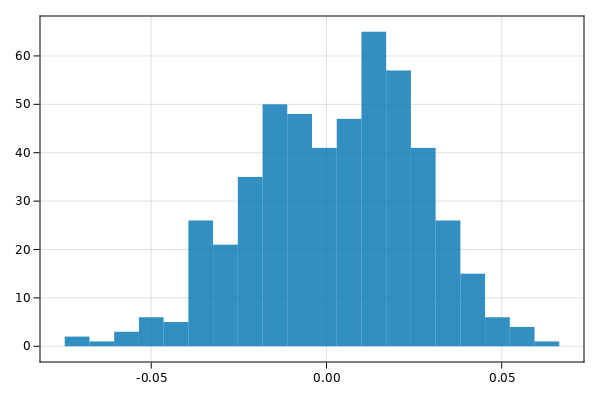

In [51]:
fig = Figure(resolution=(600, 400)) 
ax = Axis(
    fig[1, 1],
    xticklabelsize=12,
    yticklabelsize=12
)

hist!(ax, end_diff_samples, bins=20)

fig

In [52]:
estimate = (surv_ip_1[end] - surv_ip_0[end]) * 100
ci_lo, ci_hi = quantile(end_diff_samples, [0.025, 0.975]) * 100

println("difference in final survival probability")
println("  est   CI")
@printf " %0.1f%%   (%0.1f, %0.1f)" estimate ci_lo ci_hi

difference in final survival probability
  est   CI
 0.2%   (-4.5, 4.4)

In [53]:
estimate = minimum(surv_ip_1 .- surv_ip_0) * 100
ci_lo, ci_hi = quantile(min_diff_samples, [0.025, 0.975]) * 100

println("largest difference in survival probability")
println("  est   CI")
@printf " %0.1f%%   (%0.1f, %0.1f)" estimate ci_lo ci_hi

largest difference in survival probability
  est   CI
 -1.9%   (-6.1, 0.0)

The previous two confidence intervals differ from the book's, but they also change from run to run

## Section 17.5

### Program 17.4

The steps will be similar to Program 13.3, with calculation of survival curves similar to the previous program. However, survival curves will be estimated for each individual, and the final curves will be averages of those curves

1. outcome modeling, on the original data (aka "block 1")
2. prediction on expanded dataset _per individual_, see below)
    - block 2: a copy of the dataset with `qsmk` set to zero
    - block 3: a copy of the dataset with `qsmk` set to one
3. create the survival curves from the predictions, _per individual_, see below
4. average the individual curves to get marginal survival curves

#### Step 1

In [54]:
spec = @formula(
    event ~ qsmk
          + qsmk & time + qsmk & time^2
          + time + time^2
          + sex
          + race
          + age + age^2
          + education
          + smokeintensity + smokeintensity^2
          + smokeyrs + smokeyrs^2
          + exercise
          + active
          + wt71 + wt71^2
          + smkintensity82_71
)
model = glm(spec, pt_data, Binomial(), LogitLink())

StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Vector{Float64}, Binomial{Float64}, LogitLink}, GLM.DensePredChol{Float64, LinearAlgebra.Cholesky{Float64, Matrix{Float64}}}}, Matrix{Float64}}

event ~ 1 + qsmk + time + :(time ^ 2) + sex + race + age + :(age ^ 2) + education + smokeintensity + :(smokeintensity ^ 2) + smokeyrs + :(smokeyrs ^ 2) + exercise + active + wt71 + :(wt71 ^ 2) + smkintensity82_71 + qsmk & time + qsmk & :(time ^ 2)

Coefficients:
───────────────────────────────────────────────────────────────────────────────────────────
                           Coef.   Std. Error      z  Pr(>|z|)      Lower 95%     Upper 95%
───────────────────────────────────────────────────────────────────────────────────────────
(Intercept)         -9.27243      1.37893      -6.72    <1e-10  -11.9751       -6.56977
qsmk                -0.0595889    0.415358     -0.14    0.8859   -0.873675      0.754497
time                 0.0226975    0.00843733    2.69    0.0071    0.006

#### Steps 2 & 3

The model gives the information for constructing _conditional_ survival curves.

As the text says, "we can use this model to estimate the survival curves under treatment and no treatment for white men aged 61, with college education, low levels of exercise, etc. However, our goal is estimating the marginal, not the conditional", pg 218

To get the marginal survival curves, we create conditional curves and average them. To do this, we create a full person-time set for each individual twice, once with `qsmk` equal to zero, and once with `qsmk` equal to one. Then we'll create the survival curves for each individual, and average by time.

To create the individual person-time sets, we'll go row-by-row through the original data, set `death` to zero and `longevity` to 120, i.e. survived through end of follow-up, and set `qsmk` to zero or one.

We'll use two arrays to carry all of the survival curves, fill it in for each individual, then average the array.

In [55]:
survivals_qsmk0 = zeros((nrow(nhefs_all), 120))
survivals_qsmk1 = zeros((nrow(nhefs_all), 120));

The `survival_curve` function below was defined in cell 20 above. For explanation, see the text between cells 18 and 19.

In [56]:
# fill in the individual survival curves
for i in 1:nrow(nhefs_all)
    # the person_time_format function expects a DataFrame, so convert the
    # row to a DataFrame first
    frame = DataFrame(nhefs_all[i, :])
    frame.death .= 0
    frame.longevity .= 121

    # qsmk = 0 curve
    pt_block2_i = person_time_format(frame)
    pt_block2_i.qsmk .= 0
    hazard = predict(model, pt_block2_i)
    survivals_qsmk0[i, :] .= survival_curve(hazard)

    # qsmk = 1 curve
    pt_block3_i = pt_block2_i
    pt_block3_i.qsmk .= 1
    hazard = predict(model, pt_block3_i)
    survivals_qsmk1[i, :] .= survival_curve(hazard)
end

Step 4: Average the individual curves

In [57]:
surv_gform_0 = vec(mean(survivals_qsmk0, dims=1))
surv_gform_1 = vec(mean(survivals_qsmk1, dims=1));

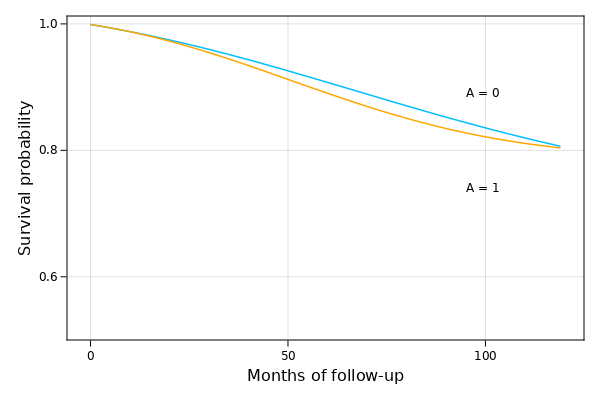

In [58]:
fig = Figure(resolution=(600, 400)) 
ax = Axis(
    fig[1, 1],
    xlabel="Months of follow-up",
    ylabel="Survival probability",
    xticklabelsize=12,
    yticklabelsize=12
)

lines!(ax, collect(0:119), surv_gform_0, color=:deepskyblue)

lines!(ax, collect(0:119), surv_gform_1, color=:orange)

text!(
    ax,
    ["A = 0", "A = 1"],
    position=[(95, 0.88), (95, 0.73)],
    textsize=12,
)

ylims!(ax, 0.5, nothing)

fig

Plot these curves over the previous version, to see how they change

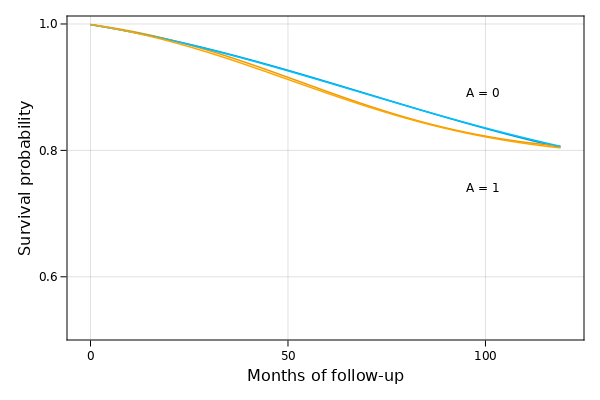

In [59]:
fig = Figure(resolution=(600, 400)) 
ax = Axis(
    fig[1, 1],
    xlabel="Months of follow-up",
    ylabel="Survival probability",
    xticklabelsize=12,
    yticklabelsize=12
)

lines!(ax, collect(0:119), surv_ip_0, color=:deepskyblue3)
lines!(ax, collect(0:119), surv_ip_1, color=:orange2)

lines!(ax, collect(0:119), surv_gform_0, color=:deepskyblue)
lines!(ax, collect(0:119), surv_gform_1, color=:orange)

text!(
    ax,
    ["A = 0", "A = 1"],
    position=[(95, 0.88), (95, 0.73)],
    textsize=12,
)

ylims!(ax, 0.5, nothing)

fig

Looks like a pretty good match

Now let's look at the mean survival curves plotted over some of the individual curves

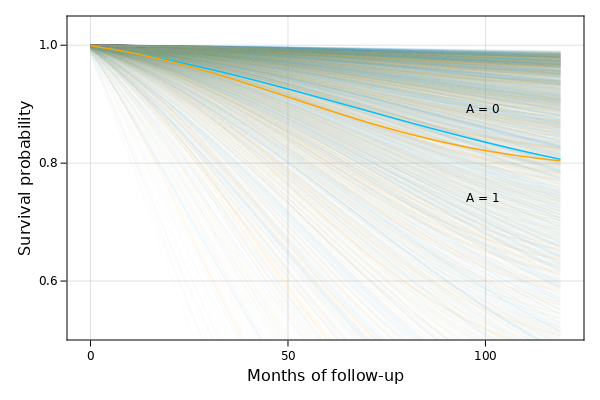

In [60]:
fig = Figure(resolution=(600, 400)) 
ax = Axis(
    fig[1, 1],
    xlabel="Months of follow-up",
    ylabel="Survival probability",
    xticklabelsize=12,
    yticklabelsize=12
)

x = collect(0:119)
for i in 1:nrow(nhefs_all)
    lines!(ax, x, survivals_qsmk0[i, :], color=(:deepskyblue, 0.02))
    lines!(ax, x, survivals_qsmk1[i, :], color=(:orange, 0.02))
end

lines!(ax, collect(0:119), surv_gform_0, color=:deepskyblue)
lines!(ax, collect(0:119), surv_gform_1, color=:orange)

text!(
    ax,
    ["A = 0", "A = 1"],
    position=[(95, 0.88), (95, 0.73)],
    textsize=12,
)

ylims!(ax, 0.5, nothing)

fig

Apparently, there is a _lot_ of variation between individuals